In [1]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import os
import apex
import copy
import random
import numpy as np
import matplotlib as mpl
import compress_pickle as cpkl

import rsatoolbox
from torchinfo import summary

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
# plt.style.use("seaborn-darkgrid")

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from ss_baselines.common.utils import plot_top_down_map

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white" 

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Notebook support or argpase
import sys; sys.argv=['']; del sys

# General config related
from configurator import get_arg_dict, generate_args

# Env config related
from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class

# region: Generating additional hyparams
CUSTOM_ARGS = [
    # General hyper parameters
    get_arg_dict("seed", int, 111),
    get_arg_dict("total-steps", int, 1_000_000),
    
    # Behavior cloning gexperiment config
    get_arg_dict("dataset-path", str, "SAVI_Oracle_Dataset_v0"),

    # SS env config
    get_arg_dict("config-path", str, "env_configs/savi/savi_ss1.yaml"),

    # Probing setting
    get_arg_dict("probe-depth", int, 1),
    get_arg_dict("probe-hid-size", int, 512),
    get_arg_dict("probe-bias", bool, False, metatype="bool"),
    
    get_arg_dict("probing-targets", str, ["category", "scene"], metatype="list"), # What to probe for 
    get_arg_dict("probing-inputs", str, 
        ["state_encoder", "visual_encoder.cnn.7", "audio_encoder.cnn.7"], metatype="list"), # What to base the probe on
    get_arg_dict("pretrained-model-name", str, None), # Simplified model name; required
    get_arg_dict("pretrained-model-path", str, None), # Path to the weights of the pre-trained model; required
    get_arg_dict("n-epochs", int, 1), # How many iteration over the whole dataset (* with caveat)
    
    # PPO Hyper parameters
    get_arg_dict("num-envs", int, 1), # Number of parallel envs. 10 by default
    get_arg_dict("num-steps", int, 150), # For each env, how many steps are collected to form PPO Agent rollout.
    get_arg_dict("num-minibatches", int, 1), # Number of mini-batches the rollout data is split into to make the updates
    get_arg_dict("update-epochs", int, 4), # Number of gradient step for the policy and value networks
    get_arg_dict("gamma", float, 0.99),
    get_arg_dict("gae-lambda", float, 0.95),
    get_arg_dict("norm-adv", bool, True, metatype="bool"),
    get_arg_dict("clip-coef", float, 0.1), # Surrogate loss clipping coefficient
    get_arg_dict("clip-vloss", bool, True, metatype="bool"),
    get_arg_dict("ent-coef", float, 0.0), # Entropy loss coef; 0.2 in SS baselines
    get_arg_dict("vf-coef", float, 0.5), # Value loss coefficient
    get_arg_dict("max-grad-norm", float, 0.5),
    get_arg_dict("target-kl", float, None),
    get_arg_dict("lr", float, 2.5e-4), # Learning rate
    get_arg_dict("optim-wd", float, 0), # weight decay for adam optim
    ## Agent network params
    get_arg_dict("agent-type", str, "ss-default", metatype="choice",
        choices=["ss-default", "custom-gru", "custom-gwt", "perceiver-gwt-gwwm"]),
    get_arg_dict("use-pose", bool, False, metatype="bool"), # Use "pose" field iin observations
    get_arg_dict("hidden-size", int, 512), # Size of the visual / audio features and RNN hidden states 
    ## Perceiver / PerceiverIO params: TODO: num_latnets, latent_dim, etc...
    get_arg_dict("pgwt-latent-type", str, "randn", metatype="choice",
        choices=["randn", "zeros"]), # Depth of the Perceiver
    get_arg_dict("pgwt-latent-learned", bool, True, metatype="bool"),
    get_arg_dict("pgwt-depth", int, 1), # Depth of the Perceiver
    get_arg_dict("pgwt-num-latents", int, 8),
    get_arg_dict("pgwt-latent-dim", int, 64),
    get_arg_dict("pgwt-cross-heads", int, 1),
    get_arg_dict("pgwt-latent-heads", int, 4),
    get_arg_dict("pgwt-cross-dim-head", int, 64),
    get_arg_dict("pgwt-latent-dim-head", int, 64),
    get_arg_dict("pgwt-weight-tie-layers", bool, False, metatype="bool"),
    get_arg_dict("pgwt-ff", bool, False, metatype="bool"),
    get_arg_dict("pgwt-num-freq-bands", int, 6),
    get_arg_dict("pgwt-max-freq", int, 10.),
    get_arg_dict("pgwt-use-sa", bool, False, metatype="bool"),
    ## Peceiver Modality Embedding related
    get_arg_dict("pgwt-mod-embed", int, 0), # Learnable modality embeddings
    ## Additional modalities
    get_arg_dict("pgwt-ca-prev-latents", bool, True, metatype="bool"), # if True, passes the prev latent to CA as KV input data

    ## Special BC
    get_arg_dict("prev-actions", bool, False, metatype="bool"),
    get_arg_dict("burn-in", int, 0), # Steps used to init the latent state for RNN component
    get_arg_dict("batch-chunk-length", int, 0), # For gradient accumulation
    get_arg_dict("dataset-ce-weights", bool, True, metatype="bool"), # If True, will read CEL weights based on action dist. from the 'dataset_statistics.bz2' file.
    get_arg_dict("ce-weights", float, None, metatype="list"), # Weights for the Cross Entropy loss
    
    ## Custom GWT Agent with BU and TD attentions
    get_arg_dict("gwt-hid-size", int, 512),
    get_arg_dict("gwt-channels", int, 32),

    ## GWTv3 Agent with custom attention, recurrent encoder and null inputs
    get_arg_dict("gwtv3-use-gw", bool, True, metatype="bool"), # Use GW at Recur. Enc. level
    get_arg_dict("gwtv3-enc-gw-detach", bool, False, metatype="bool"), # When using GW at Recurrent Encoder level, whether to detach the grads or not
    get_arg_dict("gwtv3-use-null", bool, True, metatype="bool"), # Use Null at CrossAtt level
    get_arg_dict("gwtv3-cross-heads", int, 1), # num_heads of the CrossAttn
    get_arg_dict("gwtv3-gru-type", str, "default", metatype="choice",
                    choices=["default", "layernorm"]),

    ## SSL Support
    get_arg_dict("obs-center", bool, False, metatype="bool"), # Centers the rgb_observations' range to [-0.5,0.5]
    get_arg_dict("ssl-tasks", str, None, metatype="list"), # Expects something like ["rec-rgb-vis", "rec-depth", "rec-spectr"]
    get_arg_dict("ssl-task-coefs", float, None, metatype="list"), # For each ssl-task, specifies the loss coeff. during computation

    # Eval protocol
    get_arg_dict("eval", bool, True, metatype="bool"),
    get_arg_dict("eval-every", int, int(1.5e4)), # Every X frames || steps sampled
    get_arg_dict("eval-n-episodes", int, 5),

    # Logging params
    # NOTE: While supported, video logging is expensive because the RGB generation in the
    # envs hogs a lot of GPU, especially with multiple envs 
    get_arg_dict("save-videos", bool, False, metatype="bool"),
    get_arg_dict("save-model", bool, True, metatype="bool"),
    get_arg_dict("log-sampling-stats-every", int, int(1.5e3)), # Every X frames || steps sampled
    get_arg_dict("log-training-stats-every", int, int(10)), # Every X model update
    get_arg_dict("logdir-prefix", str, "./logs/") # Overrides the default one
]
args = generate_args(CUSTOM_ARGS)

# Additional PPO overrides
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)

# Load environment config
is_SAVi = str.__contains__(args.config_path, "savi")
if is_SAVi:
    env_config = get_savi_config(config_paths=args.config_path)
else:
    env_config = get_config(config_paths=args.config_path)
# endregion: Generating additional hyparams

## Instantiate obs / act space based on args and env_config

In [3]:
# Overriding some envs parametes from the .yaml env config
env_config.defrost()
env_config.NUM_PROCESSES = 1 # Corresponds to number of envs, makes script startup faster for debugs
env_config.USE_SYNC_VECENV = True
# env_config.USE_VECENV = False
# env_config.CONTINUOUS = args.env_continuous
## In caes video saving is enabled, make sure there is also the rgb videos
env_config.freeze()
# print(env_config)

# Environment instantiation
# envs = construct_envs(env_config, get_env_class(env_config.ENV_NAME))
# Dummy environment spaces

# TODO: add dyanmicallly set single_observation_space so that RGB and RGBD based variants
# can be evaluated at thet same time
from gym import spaces
single_action_space = spaces.Discrete(4)
single_observation_space = spaces.Dict({
    "rgb": spaces.Box(shape=[128,128,3], low=0, high=255, dtype=np.uint8),
    # "depth": spaces.Box(shape=[128,128,1], low=0, high=255, dtype=np.uint8),
    "audiogoal": spaces.Box(shape=[2,16000], low=-3.4028235e+38, high=3.4028235e+38, dtype=np.float32),
    "spectrogram": spaces.Box(shape=[65,26,2], low=-3.4028235e+38, high=3.4028235e+38, dtype=np.float32)
})
# single_observation_space = envs.observation_spaces[0]
# single_action_space = envs.action_spaces[0]

single_observation_space, single_action_space

(Dict(audiogoal:Box(-3.4028235e+38, 3.4028235e+38, (2, 16000), float32), rgb:Box(0, 255, (128, 128, 3), uint8), spectrogram:Box(-3.4028235e+38, 3.4028235e+38, (65, 26, 2), float32)),
 Discrete(4))

# Loading the Category-Scene-Trajs, Scene-Category-Trajs, and Dataset's metadata

### Loads data for analysis, as well as dataset's metadata

In [4]:
# Specify file name
analysis_trajs_filename = "cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41.bz2"

# Read the filtred trajectories data
## Default format is {cat -> { scenes -> traj: []}}
with open(analysis_trajs_filename, "rb") as f:
    cats_scenes_trajs_dict = cpkl.load(f)

## Compute the equivalent scenes cat trajs format
## {scenes -> { cat -> trajs: []}}
scenes_cats_trajs_dict = {}
for cat, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    for scene, scenes_trajs in cat_scenes_trajs.items():
        if scene not in scenes_cats_trajs_dict.keys():
            scenes_cats_trajs_dict[scene] = {}
        
        scenes_cats_trajs_dict[scene][cat] = scenes_trajs

# Generic: load the dataset statistics
## Compute action coefficient for CEL of BC
dataset_stats_filepath = f"{args.dataset_path}/dataset_statistics.bz2"
# Override dataset statistics if the file already exists
if os.path.exists(dataset_stats_filepath):
    with open(dataset_stats_filepath, "rb") as f:
        dataset_statistics = cpkl.load(f)

# Extract some global metadata
# TARGET_SCENE_LIST = list(cats_scenes_trajs_dict[list(cats_scenes_trajs_dict.keys())[0]].keys())
TARGET_SCENE_LIST = list(dataset_statistics["scene_counts"].keys())
TARGET_SCENE_DICT = {scene: i for i, scene in enumerate(TARGET_SCENE_LIST)}
TARGET_CATEGORY_LIST = list(cats_scenes_trajs_dict.keys())
TARGET_CATEGORY_DICT = {cat: i for i, cat in enumerate(TARGET_CATEGORY_LIST)}

from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING
def get_category_name(idx):
    assert idx >= 0 and idx <=20, f"Invalid category index number: {idx}"

    for catname, catidx in CATEGORY_INDEX_MAPPING.items():
        if catidx == idx:
            return catname

def get_sceneid_by_idx(scene_idx):
    for k, v in TARGET_SCENE_DICT.items():
        if v == scene_idx:
            return k

C = len(TARGET_CATEGORY_LIST) # C: total number of categories
M = len(TARGET_SCENE_LIST) # M: total number of rooms, assuming all categories has N trajs for a same set of scenes.

print(f"# of categories C: {C} | # of scenes: {M}")
print(f"TARGET_CATEGORY_DICT: {TARGET_CATEGORY_DICT}")
print(f"TARGET_SCENE_DICT: {TARGET_SCENE_DICT}")
print("")

# for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
#     print(f"Cat: {catname}; Scenes: {[k for k in cat_scenes_trajs.keys()]}")

# Basic check of the scene -> categories fileted trajectories
# for scene, scenes_cat_trajs in scenes_cats_trajs_dict.items():
#     print(f"Scene: {scene}; Cats: {[k for k in scenes_cat_trajs.keys()]}")

# More detailed breakdown of the trajectories per categories then scenes
for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    print(f"{catname}:")
    for scene, scene_trajs in cat_scenes_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"\t{scene}: {traj_lengths}")
    print("")

# More detailed breakdown of the trajectories per categories then scenes
for scene, scene_cats_trajs in scenes_cats_trajs_dict.items():
    print(f"{scene}")
    for cat, cat_trajs in scene_cats_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in cat_trajs]
        print(f"\t{cat}: {traj_lengths}")
    print("")

# of categories C: 6 | # of scenes: 56
TARGET_CATEGORY_DICT: {'chair': 0, 'picture': 1, 'table': 2, 'cushion': 3, 'cabinet': 4, 'plant': 5}
TARGET_SCENE_DICT: {'gTV8FGcVJC9': 0, '5LpN3gDmAk7': 1, 'vyrNrziPKCB': 2, 'b8cTxDM8gDG': 3, 'Vvot9Ly1tCj': 4, 'rPc6DW4iMge': 5, 'PuKPg4mmafe': 6, '759xd9YjKW5': 7, 'ZMojNkEp431': 8, 'VzqfbhrpDEA': 9, 'ac26ZMwG7aT': 10, 'D7N2EKCX4Sj': 11, 'E9uDoFAP3SH': 12, 'S9hNv5qa7GM': 13, '5q7pvUzZiYa': 14, 'kEZ7cmS4wCh': 15, 'VFuaQ6m2Qom': 16, '7y3sRwLe3Va': 17, 'p5wJjkQkbXX': 18, 'V2XKFyX4ASd': 19, 'VVfe2KiqLaN': 20, 'mJXqzFtmKg4': 21, 'SN83YJsR3w2': 22, 'EDJbREhghzL': 23, 'PX4nDJXEHrG': 24, 'JmbYfDe2QKZ': 25, 'r1Q1Z4BcV1o': 26, 'aayBHfsNo7d': 27, 'r47D5H71a5s': 28, 'pRbA3pwrgk9': 29, 'Pm6F8kyY3z2': 30, 'sKLMLpTHeUy': 31, 'GdvgFV5R1Z5': 32, 'e9zR4mvMWw7': 33, 'JeFG25nYj2p': 34, 'B6ByNegPMKs': 35, 'uNb9QFRL6hY': 36, 'cV4RVeZvu5T': 37, 'D7G3Y4RVNrH': 38, 'XcA2TqTSSAj': 39, 'ur6pFq6Qu1A': 40, '29hnd4uzFmX': 41, 's8pcmisQ38h': 42, 'qoiz87JEwZ2': 43, 'ULsKaCPVFJR':

In [5]:
dataset_statistics["category_counts"]

{'chair': 7432,
 'table': 3175,
 'picture': 3455,
 'cabinet': 2643,
 'cushion': 2687,
 'sofa': 1140,
 'bed': 661,
 'chest_of_drawers': 717,
 'plant': 1614,
 'sink': 959,
 'toilet': 297,
 'stool': 634,
 'towel': 513,
 'tv_monitor': 554,
 'shower': 288,
 'bathtub': 81,
 'counter': 816,
 'fireplace': 240,
 'gym_equipment': 78,
 'seating': 866,
 'clothes': 151}

## Helpers to extract traj. data based on "category", "scene", etc...

In [6]:
# region: Categories -> Scenes
## cats_scenes_trajs_dict: dictionary structured as: {category: {scene: [traj_data]}}
# TODO: add support for the device in case tensors are returned
def get_traj_data_by_category_scene_trajIdx(trajs_dicts, category, scene, trajIdx=0, tensorize=False, device="cpu"):
    # Get a single trajectory specified by idx, for a specificed category and scene
    # TODO: maybe fix the "depth" dimension here directly ?
    obs_list_dict = trajs_dicts[category][scene][trajIdx]["edd"]["obs_list"]
    done_list = trajs_dicts[category][scene][trajIdx]["edd"]["done_list"]

    obs_dict_list = []
    target_scene_idx_list, target_category_idx_list = [], []

    T = len(obs_list_dict["rgb"])
    for t in range(T):
        obs_dict_list.append({k: v[t] for k, v in obs_list_dict.items()})
        target_scene_idx_list.append(TARGET_SCENE_DICT[scene])
        target_category_idx_list.append(CATEGORY_INDEX_MAPPING[category])

    # Tensorize if required
    if tensorize:
        done_list__th = []
        obs_dict_list__th = []

        for t, (obs_dict, done) in enumerate(zip(obs_dict_list, done_list)):
            # done_list__th.append(th.Tensor(np.array([done])[None, :]))
            done_list__th.append(th.Tensor(np.array([done])).to(device)) # TODO: make sure that the deprecation warning stops showing up. Or always stay on current Torch version.
            tmp_dict = {}
            for k, v in obs_dict.items():
                if k == "depth":
                    v = np.array(v)[:, :, None] # From (H, W) -> (H, W, 1)
                tmp_dict[k] = th.Tensor(v)[None, :].to(device)
            
            obs_dict_list__th.append(tmp_dict)
        
        return obs_dict_list__th, done_list__th, target_scene_idx_list, target_category_idx_list

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_category_scene(trajs_dicts, category, scene, max_scenes=0, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category and scene
    obs_dict_list, done_list = [], []
    target_scene_idx_list, target_category_idx_list = [], []

    N_SCENES = len(trajs_dicts[category][scene])
    res_n_scenes = N_SCENES if max_scenes <= 0 else max_scenes

    for i in range(N_SCENES):
        traj_obs_dict_list, traj_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_category_scene_trajIdx(trajs_dicts, category, scene, i, tensorize=tensorize, device=device)

        obs_dict_list.extend(traj_obs_dict_list)
        done_list.extend(traj_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)

        traj_length = len(traj_done_list)
        # print(f"Selected traj of length: {traj_length}")
        if i >= res_n_scenes - 1:
            break

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_category(trajs_dicts, category, max_scenes=0, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []

    for scene in trajs_dicts[category].keys():
        scene_obs_dict_list, scene_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_category_scene(trajs_dicts, category, scene, max_scenes=max_scenes, tensorize=tensorize, device=device)

        obs_dict_list.extend(scene_obs_dict_list)
        done_list.extend(scene_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_all_traj_data_by_category(trajs_dicts, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []

    for cat in trajs_dicts.keys():
        cat_scene_obs_dict_list, cat_scene_done_list, cat_target_scene_idxes, cat_target_category_idxes = \
            get_traj_data_by_category(trajs_dicts, cat, tensorize=tensorize, device=device)

        obs_dict_list.extend(cat_scene_obs_dict_list)
        done_list.extend(cat_scene_done_list)
        target_scene_idx_list.extend(cat_target_scene_idxes)
        target_category_idx_list.extend(cat_target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
# endregion: Categories -> Scenes


# region: Scenes -> Categories
# TODO: add "return" for target categories and scenes label
## scenes_cats_trajs_dict: dictionary structured as: {scene: {category: [traj-data]}}
def get_traj_data_by_scene_category_trajIdx(trajs_dicts, scene, category, trajIdx=0, tensorize=False, device="cpu"):
    # Get a single trajectory specified by idx, for a specificed category and scene
    # TODO: maybe fix the "depth" dimension here directly ?
    obs_list_dict = trajs_dicts[scene][category][trajIdx]["edd"]["obs_list"]
    done_list = trajs_dicts[scene][category][trajIdx]["edd"]["done_list"]
    target_scene_idx_list, target_category_idx_list = [], []

    obs_dict_list = []
    T = len(obs_list_dict["rgb"])
    for t in range(T):
        obs_dict_list.append({k: v[t] for k, v in obs_list_dict.items()})
        target_scene_idx_list.append(TARGET_SCENE_DICT[scene])
        target_category_idx_list.append(CATEGORY_INDEX_MAPPING[category])

    # Tensorize if required
    if tensorize:
        done_list__th = []
        obs_dict_list__th = []

        for t, (obs_dict, done) in enumerate(zip(obs_dict_list, done_list)):
            # done_list__th.append(th.Tensor(np.array([done])[None, :]))
            done_list__th.append(th.Tensor(np.array([done])).to(device)) # TODO: make sure that the deprecation warning stops showing up. Or always stay on current Torch version.
            tmp_dict = {}
            for k, v in obs_dict.items():
                if k == "depth":
                    v = np.array(v)[:, :, None] # From (H, W) -> (H, W, 1)
                tmp_dict[k] = th.Tensor(v)[None, :].to(device)
            
            obs_dict_list__th.append(tmp_dict)
        
        return obs_dict_list__th, done_list__th, target_scene_idx_list, target_category_idx_list
        
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_scene_category(trajs_dicts, scene, category, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category and scene
    obs_dict_list, done_list = [], []
    target_scene_idx_list, target_category_idx_list = [], []

    for i in range(len(trajs_dicts[scene][category])):
        traj_obs_dict_list, traj_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_scene_category_trajIdx(trajs_dicts, scene, category, i, tensorize=tensorize, device=device)

        obs_dict_list.extend(traj_obs_dict_list)
        done_list.extend(traj_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)

        traj_length = len(traj_done_list)
        # print(f"Selected traj of length: {traj_length}")

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_scene(trajs_dicts, scene, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []
    
    for cat in trajs_dicts[scene].keys():
        cat_obs_dict_list, cat_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_scene_category(trajs_dicts, scene, cat, tensorize=tensorize, device=device)

        obs_dict_list.extend(cat_obs_dict_list)
        done_list.extend(cat_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_all_traj_data_by_scene(trajs_dicts, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []

    for scene in trajs_dicts.keys():
        # Too rushing / lazy to change the names of the temporary list of obs
        cat_scene_obs_dict_list, cat_scene_done_list, cat_target_scene_idxes, cat_target_category_idxes = \
            get_traj_data_by_category(trajs_dicts, scene, tensorize=tensorize, device=device)

        obs_dict_list.extend(cat_scene_obs_dict_list)
        done_list.extend(cat_scene_done_list)
        target_scene_idx_list.extend(cat_target_scene_idxes)
        target_category_idx_list.extend(cat_target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
# endregion: Scenes -> Categories

# Define agents models and load them

In [7]:
# TODO seeding for reproducibility ? Make sure that we can control the generated episode trajs ?

# Loading pretrained agent
import models3
from models3 import GWTv3ActorCritic, GWTv3_1ActorCritic, GWTv3_2ActorCritic, ActorCritic_GRUBaseline

MODEL_VARIANTS_TO_STATEDICT_PATH = {
    # GWTv3 Agents

    ## GRUv3
    # region: SAVI BC GRUv3 variants: rec enc gw3 detach
    "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111": {
        "pretty_name": "GRUv3 | Seed 111",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111__2023_11_06_11_56_54_073258.conan"
            "/models/ppo_agent.19995001.ckpt.pth",
            # "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_222__2023_11_06_11_56_51_833977.conan"
        # TODO: fetch probing weights from conan and specify it here
        "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-probing/"
            "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__n_mb_50__prb_dpth_2_seed_111__2023_11_16_16_08_52_068321.conan"
    },
    # endregion: SAVI BC GRUv3 variants: rec enc gw3 detach


    ## GWTv3 H=512
    # region: SAVI BC GWTv3 variants: rec enc gw3 detach; CA uses null; seed 111
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111": {
        "pretty_name": "GWTv3 | Seed 111",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew_seed_111__2023_11_08_13_34_19_183492.musashi"
            "/models/ppo_agent.19995001.ckpt.pth",
        "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-probing/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__n_mb_50__prb_dpth_2_seed_111__2023_11_14_18_38_49_687853.musashi"
    },
    # endregion: SAVI BC GWTv3 variants: rec enc gw3 detach; CA uses null; seed 111

    # region: SAVI BC GWTv3 variants: rec enc gw3 detach; CA uses null; seed 222
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_222": {
        "pretty_name": "GWTv3 | Seed 222",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew_seed_222__2023_11_08_13_34_14_469646.musashi"
            "/models/ppo_agent.19995001.ckpt.pth",
        # NOTE: the follwoing probe weight is not that of the current seed. This experimen was not run.
        "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-probing/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__n_mb_50__prb_dpth_2_seed_111__2023_11_14_18_38_49_687853.musashi"
    },
    # endregion: SAVI BC GWTv3 variants: rec enc gw3 detach; CA uses null; seed 222


    ## GWTv3 H=64
    # region: SAVI BC GWTv3 variants: rec enc gw3 detach; CA uses null, H=64
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111": {
        "pretty_name": "[SAVi BC] PPO GWTv3 GW Detached; Use Null; LyNrm; H=64 | RGB Spectro | Seed 111",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64_seed_111__2023_11_08_13_34_18_744539.musashi"
            "/models/ppo_agent.19995001.ckpt.pth",
        "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-probing/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__n_mb_50__prb_dpth_2_seed_111__2023_11_14_18_38_49_127222.musashi"
    },
    # endregion: SAVI BC GWTv3 variants: rec enc gw3 detach; CA uses null, H=64

    # region: SAVI BC GWTv3 variants: rec enc gw3 detach; CA uses null, H=64, seed 222
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222": {
        "pretty_name": "[SAVi BC] PPO GWTv3 GW Detached; Use Null; LyNrm; H=64 | RGB Spectro | Seed 222",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64_seed_222__2023_11_08_13_37_01_281972.conan/"
            "/models/ppo_agent.19995001.ckpt.pth",
        "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-probing/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__n_mb_50__prb_dpth_2_seed_111__2023_11_14_18_38_49_127222.musashi"
    },
    # endregion: SAVI BC GWTv3 variants: rec enc gw3 detach; CA uses null, H=64, seed 222


    ## GWTv3.1 H=512
    # region: SAVI BC GWTv3.1 variants: rec enc gw3 detach; CA uses null; seed 222
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3.1__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_222": {
        "pretty_name": "[SAVi BC] PPO GWTv3.1 GW Detached; Use Null; LyNrm | RGB Spectro | Seed 222",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3.1__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew_seed_222__2023_11_15_17_05_07_136403.musashi"
            "/models/ppo_agent.7020001.ckpt.pth",
        # TODO probe this variant ?
        # "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-probing/"
        #     ""
    },
    # endregion: SAVI BC GWTv3.1 variants: rec enc gw3 detach; CA uses null; seed 222

    # region: SAVI BC GWTv3.2 variants: rec enc gw3 detach; CA uses null; seed 222
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3.2__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111": {
        "pretty_name": "[SAVi BC] PPO GWTv3.2 GW Detached; Use Null; LyNrm | RGB Spectro | Seed 111",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3.2__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew_seed_111__2023_11_18_19_46_43_762724.musashi"
            "/models/ppo_agent.5955001.ckpt.pth",
        # TODO probe this variant ?
        # "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-probing/"
        #     ""
    },
    # endregion: SAVI BC GWTv3.2 variants: rec enc gw3 detach; CA uses null; seed 222

}

# dev = th.device("cpu")
dev = th.device("cuda") # NOTE / TODO: using GPU to be more efficient ?

# 'variant named' indexed 'torch agent'
MODEL_VARIANTS_TO_AGENTMODEL = {}

for k, v in MODEL_VARIANTS_TO_STATEDICT_PATH.items():
    args_copy = copy.copy(args)
    # Override args depending on the model in use
    if k.__contains__("gwtv3.1"):
        # NOTE: this should come before "gwtv3"
        print(f"Loaded GWTv3.1 Agent: '{k}'")
        tmp_args = copy.copy(args)
        tmp_args.gwtv3_use_gw = False if k.__contains__("nogw") else True
        tmp_args.gwtv3_enc_gw_detach = True if k.__contains__("gw_detach") else True
        tmp_args.gwtv3_use_null = False if k.__contains__("nonull") else True
        tmp_args.gwtv3_gru_type = "layernorm" if k.__contains__("grulynrm") else "default"
        tmp_args.hidden_size = 64 if k.__contains__("h_64") else 512
        print(f"  Use GW: {tmp_args.gwtv3_use_gw}")
        print(f"  GW Detach: {tmp_args.gwtv3_enc_gw_detach}")
        print(f"  GW Use Null: {tmp_args.gwtv3_use_null}")
        print(f"  GruType: {tmp_args.gwtv3_gru_type}")
        print(f"  H size: {tmp_args.hidden_size}")

        agent = GWTv3_1ActorCritic(single_observation_space, single_action_space, tmp_args,
            analysis_layers=models3.GWTAGENT_DEFAULT_ANALYSIS_LAYER_NAMES + ["state_encoder.ca.mha"])
        # print(agent)
    elif k.__contains__("gwtv3.2"):
        # NOTE: this should come before "gwtv3"
        print(f"Loaded GWTv3.2 Agent: '{k}'")
        tmp_args = copy.copy(args)
        tmp_args.gwtv3_use_gw = False if k.__contains__("nogw") else True
        tmp_args.gwtv3_enc_gw_detach = True if k.__contains__("gw_detach") else True
        tmp_args.gwtv3_use_null = False if k.__contains__("nonull") else True
        tmp_args.gwtv3_gru_type = "layernorm" if k.__contains__("grulynrm") else "default"
        tmp_args.hidden_size = 64 if k.__contains__("h_64") else 512
        print(f"  Use GW: {tmp_args.gwtv3_use_gw}")
        print(f"  GW Detach: {tmp_args.gwtv3_enc_gw_detach}")
        print(f"  GW Use Null: {tmp_args.gwtv3_use_null}")
        print(f"  GruType: {tmp_args.gwtv3_gru_type}")
        print(f"  H size: {tmp_args.hidden_size}")

        agent = GWTv3_2ActorCritic(single_observation_space, single_action_space, tmp_args,
            analysis_layers=models3.GWTAGENT_DEFAULT_ANALYSIS_LAYER_NAMES + ["state_encoder.ca.mha"])
        # print(agent)
    elif k.__contains__("gwtv3"):
        print(f"Loaded GWTv3 Agent: '{k}'")
        tmp_args = copy.copy(args)
        tmp_args.gwtv3_use_gw = False if k.__contains__("nogw") else True
        tmp_args.gwtv3_enc_gw_detach = True if k.__contains__("gw_detach") else True
        tmp_args.gwtv3_use_null = False if k.__contains__("nonull") else True
        tmp_args.gwtv3_gru_type = "layernorm" if k.__contains__("grulynrm") else "default"
        tmp_args.hidden_size = 64 if k.__contains__("h_64") else 512
        print(f"  Use GW: {tmp_args.gwtv3_use_gw}")
        print(f"  GW Detach: {tmp_args.gwtv3_enc_gw_detach}")
        print(f"  GW Use Null: {tmp_args.gwtv3_use_null}")
        print(f"  GruType: {tmp_args.gwtv3_gru_type}")
        print(f"  H size: {tmp_args.hidden_size}")

        agent = GWTv3ActorCritic(single_observation_space, single_action_space, tmp_args,
            analysis_layers=models3.GWTAGENT_DEFAULT_ANALYSIS_LAYER_NAMES + ["state_encoder.ca.mha"])
        # print(agent)
        summary(agent)
    elif k.__contains__("gruv3"):
        print(f"Loaded GRUv3 Agent: '{k}'")
        tmp_args = copy.copy(args)
        tmp_args.gwtv3_gru_type = "layernorm" if k.__contains__("grulynrm") else "default"
        print(f"  GruType: {tmp_args.gwtv3_gru_type}")
        agent = ActorCritic_GRUBaseline(single_observation_space, single_action_space, tmp_args,
            analysis_layers=models3.GWTAGENT_DEFAULT_ANALYSIS_LAYER_NAMES )
        # print(agent)
        summary(agent)

    agent.eval()
    # Load the model weights
    # TODO: add map location device to use CPU only ?
    if v["state_dict_path"] != "":
        agent_state_dict = th.load(v["state_dict_path"], map_location=dev)
        agent.load_state_dict(agent_state_dict)
    agent = agent.to(dev)

    MODEL_VARIANTS_TO_AGENTMODEL[k] = agent

Loaded GRUv3 Agent: 'ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111'
  GruType: layernorm
Loaded GWTv3 Agent: 'ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111'
  Use GW: True
  GW Detach: True
  GW Use Null: True
  GruType: layernorm
  H size: 512
Loaded GWTv3 Agent: 'ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_222'
  Use GW: True
  GW Detach: True
  GW Use Null: True
  GruType: layernorm
  H size: 512
Loaded GWTv3 Agent: 'ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111'
  Use GW: True
  GW Detach: True
  GW Use Null: True
  GruType: layernorm
  H size: 64
Loaded GWTv3 Agent: 'ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222'
  Use GW: True
  GW Detach: True
  GW Use Null: True
  GruType: layernorm
  H size: 64
Loaded GWTv3.1 Agent: 'ppo_bc__s

# Process agents features, retain the relevant ones

In [22]:
## Load the subset of cached features that will be analyzed
# CACHE_DIRNAME = "cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41__ablation_agents_features__cache"
# FEATURES_CACHE_DIRNAME = f"cached_data/features/cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41"

CATEGORIES_OF_INTEREST = [
    "chair",
    # "picture",
    # "cabinet",
    # "plant",
    # "cushion",
    # "table"
]
SCENES_OF_INTEREST = [
    "gTV8FGcVJC9",
    # "D7N2EKCX4Sj",
    # "b8cTxDM8gDG",
    # "Vvot9Ly1tCj",
    # "vyrNrziPKCB"
] # ['gTV8FGcVJC9', 'b8cTxDM8gDG', 'D7N2EKCX4Sj', 'Vvot9Ly1tCj', 'vyrNrziPKCB']
TRAJ_INDICES = [
    0,
    1,
    2,
    3,
    4
] # Only select trajectories in indices of interest
ABLATIONS_OF_INTEREST = ["default", "vision", "audio", "zeros"]
LAYERS_OF_INTEREST = [
    "state_encoder", "visual_encoder.cnn.7", "audio_encoder.cnn.7",
    "state_encoder.ca.mha", "state_encoder.ca"
]
AGENTS_OF_INTEREST = [
    # GWTv3 (Gen 3)
    ## GRUv3
    "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111",
    ## GWTv3
    # "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111",
    # "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_222",
    ## GWTv3 H-64
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111",
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222", # TODO: missing probes
    ## GWTv3.1 H=512
    # "ppo_bc__savi_ss1_rgb_spectro__gwtv3.1__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_222",
    # "ppo_bc__savi_ss1_rgb_spectro__gwtv3.2__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111", # TODO: reload once trained long enough / interesting performance curves.
]

## GWT Variants: attention weights inspection

In [23]:
# Collect the relevant features from the PGWT variants
CAT_SCENE_TRAJS_FEATURES = {}

## Helper for cleaning up and preparing the recorded intermediate features
def process_analysis_feats_raw__occ_variant(raw_dict):
    result_dict = {}

    for k, v in raw_dict.items():
        if isinstance(v[0], th.Tensor):
            new_v = th.stack(v, dim=0).cpu()
        elif isinstance(v[0], tuple):
            new_v = None # TODO
            n_elements = len(v[0])
            elements = [[] for _ in range(n_elements)]
            for j in range(n_elements):
                for i in range(len(v)):
                    elements[j].append(v[i][j])
            
            new_v = [th.stack(vv, dim=0).cpu() for vv in elements]
        else:
            raise Exception(f"Unhandled type: {v[0].__class__}")
    
        result_dict[k] = new_v
    
    return result_dict

for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    if catname not in CATEGORIES_OF_INTEREST:
        continue

    if catname not in CAT_SCENE_TRAJS_FEATURES.keys():
        CAT_SCENE_TRAJS_FEATURES[catname] = {}
    print(f"{catname}:")

    for scene, scene_trajs in cat_scenes_trajs.items():
        if scene not in SCENES_OF_INTEREST:
            continue

        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"  {scene}: {traj_lengths}")

        if scene not in CAT_SCENE_TRAJS_FEATURES[catname].keys():
            CAT_SCENE_TRAJS_FEATURES[catname][scene] = {}
        
        for traj_idx, traj_data in enumerate(scene_trajs):
            if traj_idx not in TRAJ_INDICES:
                continue
            
            if traj_idx not in CAT_SCENE_TRAJS_FEATURES[catname][scene].keys():
                CAT_SCENE_TRAJS_FEATURES[catname][scene][traj_idx] = {}

            # Load the data, perform ablations if necessary
            obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
                get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, catname, scene, traj_idx, tensorize=True, device=dev)
            
            ep_length = len(obs_dict_list)
            print(f"    Traj {traj_idx}: Length: {ep_length}")

            # TODO: verify
            CAT_SCENE_TRAJS_FEATURES[catname][scene][traj_idx]["target_scene_idx_list"] = target_scene_idx_list
            CAT_SCENE_TRAJS_FEATURES[catname][scene][traj_idx]["target_category_idx_list"] = target_category_idx_list

            for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
                if agent_variant not in AGENTS_OF_INTEREST:
                    continue
                print(f"        Model variant: {agent_variant}")

                agent_raw_features = {}
                # Init the agent_rnn_state depending on the variant used
                if agent_variant.__contains__("gwtv3") or \
                   agent_variant.__contains__("gruv3"):
                    H = 64 if agent_variant.__contains__("h_64") else 512 # Tmp workaround
                    agent_rnn_state = th.zeros((1, H), device=dev)
                    modality_features = {
                        "audio": agent_rnn_state.new_zeros([1, H]),
                        "visual": agent_rnn_state.new_zeros([1, H])
                    }
                # print(f"          {list(agent_rnn_state.shape)}")
                
                for t, (obs_th, done_th) in enumerate(zip(obs_dict_list, done_list)):
                    
                    masks = 1. - done_th[:, None]
                    with th.no_grad():
                        _, _, _, _, \
                        _, _, agent_rnn_state, modality_features, _ = \
                            agent_model.act(obs_th, agent_rnn_state, masks=masks, 
                                modality_features=modality_features, ssl_tasks=args.ssl_tasks, single_step=True)

                    # Collecting intermediate layers results
                    for k, v in agent_model._features.items():
                        if k not in LAYERS_OF_INTEREST:
                            continue # Skip irrelevant layers
                        if k not in list(agent_raw_features.keys()):
                            agent_raw_features[k] = []
                        agent_raw_features[k].append((v[0].cpu(), v[1].cpu()) if isinstance(v, tuple) else v.cpu())
                
                agent_layers_features = process_analysis_feats_raw__occ_variant(agent_raw_features)
                del agent_raw_features

                CAT_SCENE_TRAJS_FEATURES[catname][scene][traj_idx][agent_variant] = \
                    agent_layers_features
                
                # Caching features: TODO

            del obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

chair:
  gTV8FGcVJC9: [28, 10, 46, 9, 6]
    Traj 0: Length: 28
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222


    Traj 1: Length: 10
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222
    Traj 2: Length: 46
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222
    Traj 3: Length: 9
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_

# Probing

In [24]:
# NOTE:Override the probe config appropriately
### Probe depth = 2; probe hid size 1024
args.probe_depth = 2
args.probe_hid_size = 512
args.probe_bias = False

# Loading the probe data
# Scene list for probe target label generation
SCENES = list(dataset_statistics["scene_counts"].keys())
CATEGORIES = list(dataset_statistics["category_counts"].keys())

N_SCENES = len(SCENES)
N_CATEGORIES = len(CATEGORIES)

VIS_LAST_M_FRAMES = 3 # 3
AUD_FRST_N_FRAMES = 9 # 10

# NOTE: AGENTS_OF_INTEREST inherited from the RSA ablation feature computations

# Define the target of probing
## "category" -> how easy to predict category based on the learned features / inputs
## "scene" -> how easy to predict scene based on the learned features / inputs
PROBING_TARGETS = {}
for probe_target in args.probing_targets:
    if probe_target == "category":
        PROBING_TARGETS["category"] = {}
        PROBING_TARGETS["category"]["n_classes"] = N_CATEGORIES
    elif probe_target == "scene":
        PROBING_TARGETS["scene"] = {}
        PROBING_TARGETS["scene"]["n_classes"] = N_SCENES

# TODO: redefinte probing inputs based on the nature of the agent
# so this has to be done in the for agent ... loop

# Class for a generic linear probe network
class GenericProbeNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, depth=1, hid_size=512, bias=False):
        super().__init__()
        assert depth >= 1, "Probe not deep enough: {depth}"
            
        hiddens = [hid_size for _ in range(depth)]
        network = []
        for h0, h1 in zip([input_dim, *hiddens[:-1]], [*hiddens[1:], output_dim]):
            network.append(nn.Linear(h0, h1, bias=bias))
            network.append(nn.ReLU())
        network.pop()
            
        self.network = nn.Sequential(*network)
    
    def forward(self, x):
        return self.network(x)

CAT_SCENE_TRAJ_PROBING_RESULTS = {
    cat: {
        scene: {
            traj_idx: {
                agent: {
                    probe_target_name: {

                    } for probe_target_name in ["category", "scene"]
                } for agent, _ in traj_dict.items() if agent not in ["target_scene_idx_list", "target_category_idx_list"]
                # } for agent in traj_dict
            } for traj_idx, traj_dict in scene_dict.items()
        } for scene, scene_dict in cat_dict.items()
    } for cat, cat_dict in CAT_SCENE_TRAJS_FEATURES.items()
}
OH_EYE_MAP = {
    "category": np.eye(21),
    "scene": np.eye(56)
}

# Accumulate probs for correct classification across "all" trajectories
# for summarized stats about the quality of the features.
ALL_TRAJ_PROBING_STATS = {}
    
print("## Generating probe networks for agents")
for cat, cat_dict in CAT_SCENE_TRAJS_FEATURES.items():
    print(f"  {cat}")
    for scene, scene_dict in cat_dict.items():
        print(f"    {scene}")
        for traj_idx, traj_dict in scene_dict.items():
            T = len(traj_dict["target_category_idx_list"])
            print(f"      Traj: {traj_idx}; Length: {T}")

            any_agent = list(traj_dict.keys())[0]

            aud_frst_n_frames = AUD_FRST_N_FRAMES if AUD_FRST_N_FRAMES else T
            vis_last_m_frames = VIS_LAST_M_FRAMES if VIS_LAST_M_FRAMES else T

            for agent_name, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
                if agent_name not in AGENTS_OF_INTEREST:
                    continue
                print(f"        Agent: {agent_name}")
                
                # Define which fields of an agent to use for the probes
                if agent_name.__contains__("gru") or \
                   agent_name.__contains__("pgwt"):
                    PROBING_INPUTS = ["state_encoder", "visual_encoder.cnn.7", "audio_encoder.cnn.7"]
                    if agent_name.__contains__("rec_rgb_vis_ae_5"):
                        PROBING_INPUTS.remove("visual_encoder.cnn.7")
                        PROBING_INPUTS.append("visual_encoder.linear.1")
                elif agent_name.__contains__("gwt_bu") or \
                    agent_name.__contains__("gwt_td"):
                    PROBING_INPUTS = ["state_encoder", "visual_embedding", "audio_embedding"]
                elif agent_name.__contains__("gwtv3") or \
                     agent_name.__contains__("gruv3"):
                    PROBING_INPUTS = ["state_encoder", "visual_encoder.cnn.7", "audio_encoder.cnn.7"]
                
                if agent_name not in ALL_TRAJ_PROBING_STATS.keys():
                    ALL_TRAJ_PROBING_STATS[agent_name] = {}
                
                # Instantiating probes
                PROBES_METADATA = {}
                for probe_target_name, probe_target_info in PROBING_TARGETS.items():
                    if probe_target_name not in ALL_TRAJ_PROBING_STATS[agent_name].keys():
                        ALL_TRAJ_PROBING_STATS[agent_name][probe_target_name] = {}

                    if probe_target_name not in PROBES_METADATA.keys():
                        PROBES_METADATA[probe_target_name] = {}
                    
                    for probe_input in PROBING_INPUTS: # NOTE: maybe switch order with the MODEL_VARIANTS ???

                        if probe_input not in PROBES_METADATA[probe_target_name].keys():
                            PROBES_METADATA[probe_target_name][probe_input] = {}

                        # TODO: make the probe's input dim adapt to what will actually be probed.
                        hid_size = 64 if agent_name.__contains__("h_64") else 512
                        PROBES_METADATA[probe_target_name][probe_input]["probe_input_dim"] = hid_size
                        PROBES_METADATA[probe_target_name][probe_input]["probe_output_dim"] = probe_target_info["n_classes"]

                    # Dictionary that will holds the probe networks and their optimizers
                    # PROBES = copy.copy(PROBES_METADATA)
                    for probe_input in PROBING_INPUTS: # NOTE: maybe switch order with the MODEL_VARIANTS ???
                        if probe_input not in ALL_TRAJ_PROBING_STATS[agent_name][probe_target_name].keys():
                            ALL_TRAJ_PROBING_STATS[agent_name][probe_target_name][probe_input] = []
                        
                        probe_input_dim = PROBES_METADATA[probe_target_name][probe_input]["probe_input_dim"]
                        probe_output_dim = PROBES_METADATA[probe_target_name][probe_input]["probe_output_dim"]

                        print(f"          {probe_target_name}|{probe_input}")
                        probe_network = GenericProbeNetwork(probe_input_dim, probe_output_dim,
                                                            args.probe_depth, args.probe_hid_size, args.probe_bias).to(dev)

                        # Load the trained weights of the probe
                        probe_weight_savepath = f"{MODEL_VARIANTS_TO_STATEDICT_PATH[agent_name]['probe_path']}/models/{probe_target_name}__{probe_input}__probe.pth"
                        # print(f"  Probe save weights: {os.path.exists(probe_weight_savepath)}")

                        if agent_name in ["ppo_gru__random", "ppo_pgwt__random"]:
                            probe_state_dict = th.load(probe_weight_savepath)() # TODO: retrain proper ppo_XXX_random baseline that store the state dict instead of fn..
                        else:
                            probe_state_dict = th.load(probe_weight_savepath)
                        probe_network.load_state_dict(probe_state_dict)

                        probe_targets = traj_dict[{
                            "category": "target_category_idx_list",
                            "scene": "target_scene_idx_list"
                        }[probe_target_name]]
                        probe_targets = th.LongTensor(probe_targets)
                        
                        # print(traj_dict.keys())
                        features = traj_dict[agent_name][probe_input]
                        if len(features) == 2 and probe_input == "state_encoder":
                            features = features[0]
                        # Get traj features correponding toe "default" ablation
                        # which is just iterating over observations following
                        # the default setting of the agent training, no actual ablation
                        features = features[:, 0, :]
                        # print(f"    {features.shape}")
                        with th.no_grad():
                            probe_logits = probe_network(features.to(dev))
                        probe_probs = F.softmax(probe_logits, dim=-1)
                        predicted_idxes = probe_probs.argmax(dim=1).cpu().numpy()
                        predicted_idxes_oh = [OH_EYE_MAP[probe_target_name][cidx] for cidx in predicted_idxes]
                        
                        correct_idxes = probe_targets.int().tolist()
                        correct_idxes_oh = [OH_EYE_MAP[probe_target_name][cidx] for cidx in correct_idxes]

                        # TODO: optim over here desirable
                        if probe_target_name == "category":
                            correct_class_ids = [get_category_name(cidx) for cidx in correct_idxes]
                            predicted_class_ids = [get_category_name(cidx) for cidx in predicted_idxes]
                        elif probe_target_name == "scene":
                            correct_class_ids = [get_sceneid_by_idx(cidx) for cidx in correct_idxes]
                            predicted_class_ids = [get_sceneid_by_idx(cidx) for cidx in predicted_idxes]
                        else:
                            raise NotImplementedError(f"Unsuported probe_target_name: {probe_target_name}")

                        # print(correct_class_ids)
                        # print(predicted_class_ids)
                        # print(f"    {probe_logits.shape} | {probe_probs.sum(dim=-1).sum()}")
                        # print(f"    {probe_targets.shape}")

                        # Compat between version with and without SSL task rec-rgb-vis-ae-5
                        if probe_input == "visual_encoder.linear.1" and \
                            agent_name.__contains__("rec-rgb-vis-ae-5"):
                            probe_input = "visual_encoder.linear.1"
                        
                        CAT_SCENE_TRAJ_PROBING_RESULTS[cat][scene][traj_idx][agent_name][probe_target_name][probe_input] = {
                            "probs": probe_probs.cpu().numpy(),
                            
                            "correct_idxes": correct_idxes,
                            "predicted_idxes": predicted_idxes,
                            
                            "correct_class_ids": correct_class_ids,
                            "predicted_class_ids": predicted_class_ids,
                            
                            "correct_idxes_oh": correct_idxes_oh,
                            "predicted_idxes_oh": predicted_idxes_oh
                        }

                        # Accumuluting stats for overview metrics
                        success_rate = correct_idxes == predicted_idxes
                        # correct_idxes_probs = [pv[ix].item() for ix, pv in zip(correct_idxes, probe_probs)] # Predicted probablities at ground truth's index
                        if probe_target_name == "category":
                            if probe_input in ["visual_encoder.cnn.7", "visual_embedding"]:
                                # When probing "category" based on visual feats, only the LAST_M_FRAMES
                                # are considered relevant
                                # correct_idxes_probs = correct_idxes_probs[-vis_last_m_frames:]
                                success_rate = correct_idxes[-vis_last_m_frames:] == predicted_idxes[-vis_last_m_frames:]
                            elif probe_input in ["audio_encoder.cnn.7", "audio_embedding"]:
                                # WHen probing "category" based on audio feats, only the FRST_N_FRAMES
                                # are considered relevant
                                # correct_idxes_probs = correct_idxes_probs[:aud_frst_n_frames]
                                success_rate = correct_idxes[:aud_frst_n_frames] == predicted_idxes[:aud_frst_n_frames]

                        ALL_TRAJ_PROBING_STATS[agent_name][probe_target_name][probe_input].extend(
                            success_rate)
                    
                    print("")

# CAT_SCENE_TRAJ_PROBING_RESULTS

## Generating probe networks for agents
  chair
    gTV8FGcVJC9
      Traj: 0; Length: 28
        Agent: ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111
          category|state_encoder
          category|visual_encoder.cnn.7
          category|audio_encoder.cnn.7

          scene|state_encoder
          scene|visual_encoder.cnn.7
          scene|audio_encoder.cnn.7

        Agent: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111
          category|state_encoder
          category|visual_encoder.cnn.7
          category|audio_encoder.cnn.7

          scene|state_encoder
          scene|visual_encoder.cnn.7
          scene|audio_encoder.cnn.7

        Agent: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222
          category|state_encoder
          category|visual_encoder.cnn.7
          category|audio_encoder.cnn.7

          scene|state_enc

In [25]:
AGENTS_OF_INTEREST = [
    # Gen 3
    ## GRU v3 H=512
    "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111",
    ## GWTv3 H=512
    # "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111",
    # "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_222",
    ## GWTv3 H=64
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111",
    # "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222",

]

agent_list = [a for a in ALL_TRAJ_PROBING_STATS.keys() if a in AGENTS_OF_INTEREST]

AGENTNAME_TO_PRETTYNAME = {
    # Gen 3
    ## GRU v3 H=512
    "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111": "GRU H=512 111",
    ## GWTv3 H=512
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111": "GW H=512 111",
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_222": "GW H=512 222",
    ## GWTv3 H=64
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111": "GW H=64 111",
    "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222": "GW H=64 222",
}

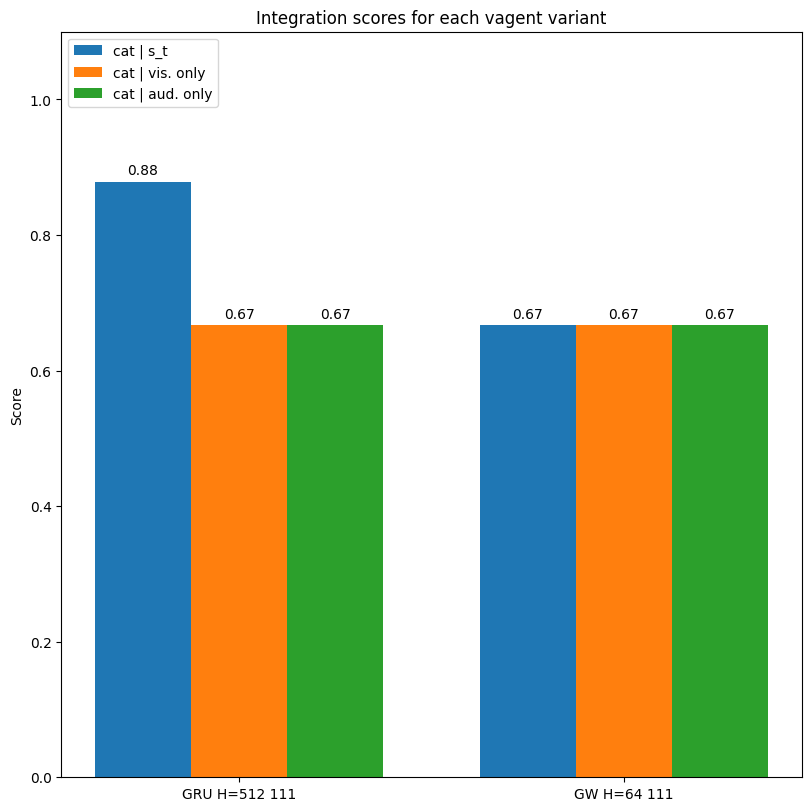

In [26]:
fig, ax = plt.subplots(1,1, figsize=(8,8), layout="constrained")

probe_stats_means = {
    "cat | s_t": [np.mean(
        ALL_TRAJ_PROBING_STATS[agentname]["category"]["state_encoder"]
    ) for agentname in agent_list],

    # cat
    "cat | vis. only": [np.mean(ALL_TRAJ_PROBING_STATS[agentname]["category"]["visual_encoder.cnn.7"])
        for agentname in agent_list],
    "cat | aud. only": [np.mean(ALL_TRAJ_PROBING_STATS[agentname]["category"]["visual_encoder.cnn.7"])
        for agentname in agent_list],
}

x = np.arange(len(agent_list))
# width = 0.25
width = 1.0 / (len(list(probe_stats_means.keys()))+1)
multiplier = 0

for attribute, measurement in probe_stats_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt="%.2f")
    multiplier +=1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Integration scores for each vagent variant')
ax.set_xticks(x + width, [AGENTNAME_TO_PRETTYNAME[name] for name in agent_list])
ax.legend(loc='upper left')#, ncol=len(probe_stats_means.keys()))
ax.set_ylim(0, 1.1)

plt.show()

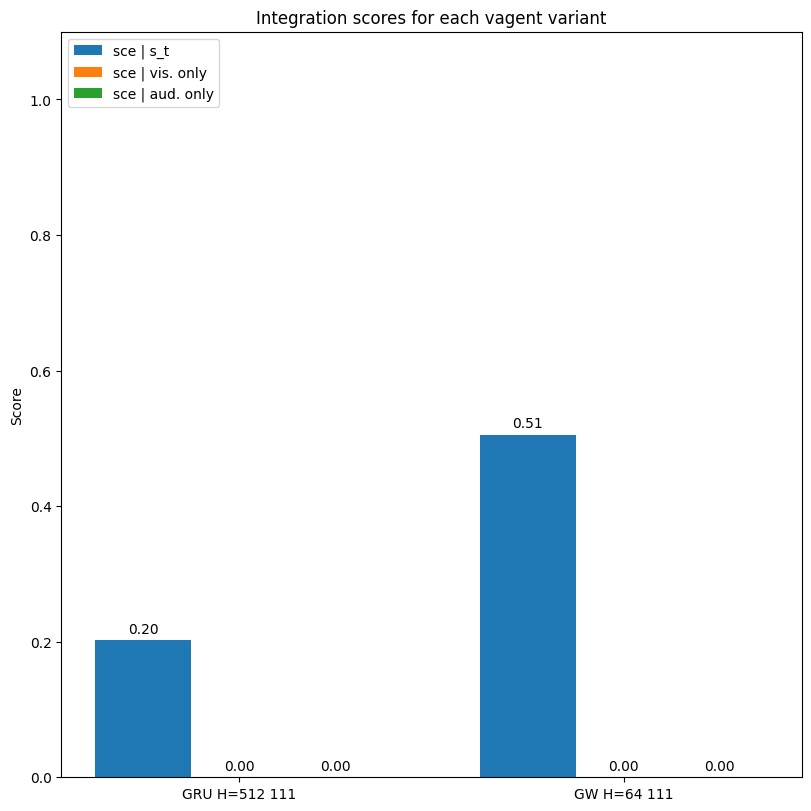

In [27]:
fig, ax = plt.subplots(1,1, figsize=(8,8), layout="constrained")

probe_stats_means = {
    "sce | s_t": [np.mean(
        ALL_TRAJ_PROBING_STATS[agentname]["scene"]["state_encoder"]
    ) for agentname in agent_list],
    
    # Scene
    "sce | vis. only": [np.mean(ALL_TRAJ_PROBING_STATS[agentname]["scene"]["audio_encoder.cnn.7"])
        for agentname in agent_list],
    "sce | aud. only": [np.mean(ALL_TRAJ_PROBING_STATS[agentname]["scene"]["audio_encoder.cnn.7"])
        for agentname in agent_list],
}

x = np.arange(len(agent_list))
# width = 0.25
width = 1.0 / (len(list(probe_stats_means.keys()))+1)
multiplier = 0

for attribute, measurement in probe_stats_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt="%.2f")
    multiplier +=1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Integration scores for each vagent variant')
ax.set_xticks(x + width, [AGENTNAME_TO_PRETTYNAME[name] for name in agent_list])
ax.legend(loc='upper left')#, ncol=len(probe_stats_means.keys()))
ax.set_ylim(0, 1.1)

plt.show()

## Step-wise probing accuracy based analysis

In [28]:
# CATEGORIES_OF_INTEREST_PLOT = [
#     "chair",
#     # "picture",
#     # "cabinet",
#     # "plant",
#     # "cushion",
#     # "table"
# ]

# SCENES_OF_INTEREST_PLOT = [
#     "gTV8FGcVJC9",
#     # "D7N2EKCX4Sj",
#     # "b8cTxDM8gDG",
#     # "Vvot9Ly1tCj",
#     # "vyrNrziPKCB"
# ]

# AGENTS_OF_INTEREST_PLOT = [
#     # Gen 3
#     ## GRU v3
#     "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111",
#     ## GWT v3 variants
#     "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111",
# ]

# TRAJ_INDICES_PLOT = [
#     0,
#     # 1,
#     # 2,
#     # 3,
#     # 4
# ] # Only select trajectories in indices of interest

# COLIDX_MAP = {
#     "category": {
#         "state_encoder": 0,
#         "visual_encoder.cnn.7": 3,
#         "visual_encoder.linear.1": 3,
#         "visual_embedding": 3,
#         "audio_encoder.cnn.7": 6,
#         "audio_embedding": 6,
#     },
#     "scene": {
#         "state_encoder": 1,
#         "visual_encoder.cnn.7": 4,
#         "visual_encoder.linear.1": 4,
#         "visual_embedding": 4,
#         "audio_encoder.cnn.7": 7,
#         "audio_embedding": 7,
#     }
# }
# for cat, cat_dict in CAT_SCENE_TRAJ_PROBING_RESULTS.items():
#     if cat not in CATEGORIES_OF_INTEREST_PLOT:
#         continue
#     print(f"  {cat}")

#     for scene, scene_dict in cat_dict.items():
#         if scene not in SCENES_OF_INTEREST_PLOT:
#             continue
#         print(f"    {scene}")

#         for traj_idx, traj_dict in scene_dict.items():
#             if traj_idx not in TRAJ_INDICES_PLOT:
#                 continue

#             T = len(CAT_SCENE_TRAJS_FEATURES[cat][scene][traj_idx]["target_category_idx_list"])

#             print(f"     Traj: {traj_idx} | Length: {T}")


#             # Load the current trajectory's data
#             obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
#                 get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, cat, scene, traj_idx, tensorize=False)

#             for agent_name, agent_dict in traj_dict.items():
#                 if agent_name not in AGENTS_OF_INTEREST_PLOT:
#                     continue
#                 fig, axes = plt.subplots(8, T, figsize=(T * 4, 8 * 4))
#                 for t in range(T):
#                     axes[2, t].imshow(obs_dict_list[t]["rgb"])
#                     axes[2, t].set_xlabel(f"t = {t}", fontsize=18)
#                     axes[2, t].xaxis.set_label_position("top")
#                     axes[5, t].imshow(obs_dict_list[t]["spectrogram"].reshape(65, -1))
#                     axes[5, t].set_xlabel(f"t = {t}", fontsize=18)
#                     axes[5, t].xaxis.set_label_position("top")

                
#                 for i, ylabel in zip(
#                         [j for j in range(8)],
#                         ["cat | state", "scene | state", "Vision", "cat | vision", "scene | vision", "Audio", "cat | audio", "scene | audio"]
#                     ):
#                     axes[i, 0].set_ylabel(ylabel, fontsize=18)
                
#                 fig.suptitle(f"Step-wise probe ana.: {cat} | Scene: {scene} | Traj: {traj_idx} | {agent_name}", fontsize=20)

#                 # print(f"          {list(agent_dict.keys())}")
#                 print(f"        Agent: {agent_name}")
                
#                 for probe_target_name, probe_target_dict in agent_dict.items():
#                     # print(f"            {list(probe_target_dict.keys())}")
#                     print(f"            {probe_target_name}")

#                     xs = np.arange(21 if probe_target_name == "category" else 56)

#                     for probe_input, probe_input_dict in probe_target_dict.items():

#                         # print(f"      {list(probe_input_dict.keys())}")
#                         print(f"              {probe_input}")

#                         # print(probe_target_name)
#                         # print(probe_target_dict.keys())
#                         probs = probe_input_dict["probs"]
                        
#                         correct_idxes = probe_input_dict["correct_idxes"]
#                         predicted_idxes = probe_input_dict["predicted_idxes"]

#                         correct_idxes_oh = probe_input_dict["correct_idxes_oh"]
#                         predicted_idxes_oh = probe_input_dict["predicted_idxes_oh"]

#                         correct_class_ids = probe_input_dict["correct_class_ids"]
#                         predicted_class_ids = probe_input_dict["predicted_class_ids"]
                        
#                         # traj_length = probs.shape
#                         # print(f"                {probs.shape}")
                        
#                         col_idx = COLIDX_MAP[probe_target_name][probe_input]
                
#                         BAR_COLORS = ["gray" for _ in range(21 if probe_target_name=="category" else 56)]
#                         for t in range(T):
#                             t_bar_colors = copy.copy(BAR_COLORS)
#                             # print(correct_idxes_oh[t].argmax())
#                             t_bar_colors[predicted_idxes_oh[t].argmax()] = "orange"
#                             t_bar_colors[correct_idxes_oh[t].argmax()] = "green"
#                             axes[col_idx, t].bar(xs, probs[t], color=t_bar_colors)
#                             gt_vs_pred = f"GT: {correct_class_ids[t]}\nPR: {predicted_class_ids[t]}"
#                             axes[col_idx, t].set_xlabel(gt_vs_pred, fontsize=16)
#                             axes[col_idx, t].xaxis.set_label_position("top")
#                             axes[col_idx, t].set_ylim([0,1.1])
#                             axes[col_idx, t].grid(axis="y")

#                 for t in range(T):
#                     for i in range(8):
#                         axes[i, t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
#                         axes[i, t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)

## Summarized step-wise probing result: acc. of the correct class only

In [29]:
# TODO: also integrated over category / scene / trajectory
AGENT_CORRECT_TARGET_PROBS = {}

for cat, cat_dict in CAT_SCENE_TRAJ_PROBING_RESULTS.items():
    if cat not in CATEGORIES_OF_INTEREST:
        continue
    print(f"  {cat}")

    if cat not in AGENT_CORRECT_TARGET_PROBS.keys():
        AGENT_CORRECT_TARGET_PROBS[cat] = {}

    for scene, scene_dict in cat_dict.items():
        if scene not in SCENES_OF_INTEREST:
            continue
        print(f"    {scene}")

        if scene not in AGENT_CORRECT_TARGET_PROBS[cat].keys():
            AGENT_CORRECT_TARGET_PROBS[cat][scene] = {}

        for traj_idx, traj_dict in scene_dict.items():
            if traj_idx not in TRAJ_INDICES:
                continue

            if traj_idx not in AGENT_CORRECT_TARGET_PROBS[cat][scene].keys():
                AGENT_CORRECT_TARGET_PROBS[cat][scene][traj_idx] = {}

            T = len(CAT_SCENE_TRAJS_FEATURES[cat][scene][traj_idx]["target_category_idx_list"])

            print(f"     Traj: {traj_idx} | Length: {T}")

            # Load the current trajectory's data
            obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
                get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, cat, scene, traj_idx, tensorize=False)

            for agent_name, agent_dict in traj_dict.items():
                # print(f"          {list(agent_dict.keys())}")
                print(f"        Agent: {agent_name}")
                
                if agent_name not in AGENT_CORRECT_TARGET_PROBS.keys():
                    AGENT_CORRECT_TARGET_PROBS[cat][scene][traj_idx][agent_name] = {}

                for probe_target_name, probe_target_dict in agent_dict.items():
                    # print(f"            {list(probe_target_dict.keys())}")
                    print(f"            {probe_target_name}")

                    if probe_target_name not in AGENT_CORRECT_TARGET_PROBS.keys():
                        AGENT_CORRECT_TARGET_PROBS[cat][scene][traj_idx][agent_name][probe_target_name] = {}
                    
                    probs = probe_target_dict["state_encoder"]["probs"]
                    correct_idxes = probe_target_dict["state_encoder"]["correct_idxes"]

                    # print(f"T: {T}, shape: {probs.shape}, shape 2: {len(correct_idxes)}")

                    AGENT_CORRECT_TARGET_PROBS[cat][scene][traj_idx][agent_name][probe_target_name] = \
                      [probs[t, correct_idxes[t]] for t in range(T)]

# Plotting
# fig, axes = plt.subplots(1, 2, figsize=(2 * 4, 4))

# # Plot verbosity
# axes[0].set_xlabel("Time steps")
# axes[1].set_xlabel("Time steps")

# axes[0].set_title("Category probe accuracy | GW")
# axes[1].set_title("Scene probe accuracy | GW")

# for i in range(2):
#     axes[i].set_ylim([-0.05, 1.05])

# # Plot lines
# agent_model_name = "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111"
# axes[0].plot(AGENT_CORRECT_TARGET_PROBS["chair"]["gTV8FGcVJC9"][0][agent_model_name]["category"], label="GRUv3", linewidth=1.25, linestyle="dashed",)
# axes[1].plot(AGENT_CORRECT_TARGET_PROBS["chair"]["gTV8FGcVJC9"][0][agent_model_name]["scene"], label="GRUv3", linewidth=1.25, linestyle="dashed",)

# agent_model_name = "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111"
# axes[0].plot(AGENT_CORRECT_TARGET_PROBS["chair"]["gTV8FGcVJC9"][0][agent_model_name]["category"], c="green", label="GWTv3", linewidth=1.25, linestyle="dashed",)
# axes[1].plot(AGENT_CORRECT_TARGET_PROBS["chair"]["gTV8FGcVJC9"][0][agent_model_name]["scene"], c="green", label="GWTv3", linewidth=1.25, linestyle="dashed",)

# # Set legend using dashed lines before doing the dots / scater
# axes[0].legend()

# # Plot dots / scater plot of probs, timesteps tuples
# # TODO: make the xs generation more flexible, base it on the current trajectory length
# xs = np.arange(28)
# agent_model_name = "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111"
# axes[0].scatter(xs, AGENT_CORRECT_TARGET_PROBS["chair"]["gTV8FGcVJC9"][0][agent_model_name]["category"], label="GRUv3", linewidth=1.25, linestyle="dashed",)
# axes[1].scatter(xs, AGENT_CORRECT_TARGET_PROBS["chair"]["gTV8FGcVJC9"][0][agent_model_name]["scene"], label="GRUv3", linewidth=1.25, linestyle="dashed",)

# agent_model_name = "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111"
# axes[0].scatter(xs, AGENT_CORRECT_TARGET_PROBS["chair"]["gTV8FGcVJC9"][0][agent_model_name]["category"], s=18, c="green")
# axes[1].scatter(xs, AGENT_CORRECT_TARGET_PROBS["chair"]["gTV8FGcVJC9"][0][agent_model_name]["scene"], s=18, c="green")

# fig.show()

  chair
    gTV8FGcVJC9
     Traj: 0 | Length: 28
        Agent: ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111
            category
            scene
        Agent: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111
            category
            scene
        Agent: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222
            category
            scene
     Traj: 1 | Length: 10
        Agent: ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111
            category
            scene
        Agent: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111
            category
            scene
        Agent: ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222
            category
            scene
     Traj: 2 |

In [30]:
# # Plotting attention masks for the GWTv3 variant, vertically
# MOD_AXIS_TO_NAME = {0: "Audio", 1: "Vision", 2: r"Prev. state $h_{t-1}$", 3: "Null"}
# MOD_AXIS_TO_COLOR = { 0: "green", 1: "blue", 2: "deeppink", 3: "grey"}

# def plot_att_weights(catname, scene, traj_idx, agent_name_pretty, att_weights, agent_name):

#     # Plot prototype
#     fig, axes = plt.subplots(3, 1, figsize=(8, 3 * 4))

#     ep_length = att_weights.shape[0]
#     x = np.arange(ep_length)

#     if agent_name.__contains__("gwtv3.1"):
#         for mod_axis in range(4):
#             axes[2].plot(x, att_weights[:, 0, mod_axis], linewidth=1.25, linestyle="dashed",
#                 label=MOD_AXIS_TO_NAME[mod_axis],
#                 color=MOD_AXIS_TO_COLOR[mod_axis])
#         axes[2].legend() # add legend based on lines only

#         for mod_axis in range(4):
#             axes[2].scatter(x, att_weights[:, 0, mod_axis], s=18,
#                 label=MOD_AXIS_TO_NAME[mod_axis],
#                 color=MOD_AXIS_TO_COLOR[mod_axis])
#     else:
#         for modality_idx in range(3):
#             for mod_axis in range(4):
#                 axes[modality_idx].plot(x, att_weights[:, modality_idx, mod_axis], linewidth=1.25, linestyle="dashed",
#                     label=MOD_AXIS_TO_NAME[mod_axis],
#                     color=MOD_AXIS_TO_COLOR[mod_axis])
            
#             for mod_axis in range(4):
#                 axes[modality_idx].scatter(x, att_weights[:, modality_idx, mod_axis], s=18,
#                     label=MOD_AXIS_TO_NAME[mod_axis],
#                     color=MOD_AXIS_TO_COLOR[mod_axis])
    
#     # Average attention across modalities
#     # for mod_axis in range(4):
#     #     axes[2].plot(x, att_weights.mean(1)[:, mod_axis], linewidth=1.25, linestyle="dashed",
#     #         label=MOD_AXIS_TO_NAME[mod_axis],
#     #         color=MOD_AXIS_TO_COLOR[mod_axis])
#     #     axes[2].scatter(x, att_weights.mean(1)[:, mod_axis], s=18,
#     #         label=MOD_AXIS_TO_NAME[mod_axis],
#     #         color=MOD_AXIS_TO_COLOR[mod_axis])

#     for idx in range(3):
#         axes[idx].set_ylim([-0.05, 1.05])

#     if idx == 2:
#         axes[idx].set_xlabel("Time steps", fontsize=11)
    
#     # axes[0].set_ylabel("Attention weights", fontsize=15)
#     axes[0].set_ylabel("Audio-based", fontsize=15)
#     axes[1].set_ylabel("Vision-based", fontsize=15)
#     axes[2].set_ylabel("GW-based", fontsize=15)
#     # axes[2].legend()

#     # Very long title
#     # fig.suptitle(f"Cat: {catname} | Scene: {scene} | Traj. {traj_idx} | {agent_name_pretty}", fontsize=16)
#     # Shorter title
#     fig.suptitle(f"[ {catname} | {scene} | {traj_idx} ] {agent_name_pretty}")
#     # fig.legend(fontsize=15)
#     fig.tight_layout()

# for catname, cat_data in CAT_SCENE_TRAJS_FEATURES.items():

#     for scene, scene_data in cat_data.items():

#         for traj_idx, traj_data in scene_data.items():

#             for agent_name, agent_data in traj_data.items():
                
#                 if agent_name in ["target_scene_idx_list", "target_category_idx_list"]:
#                     continue
                
#                 if not agent_name.__contains__("gwtv3"):
#                     continue
                
#                 att_weights = agent_data["state_encoder.ca.mha"][1][:, 0, :, :]

#                 agent_name_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_name]["pretty_name"]
#                 plot_att_weights(catname, scene, traj_idx, agent_name_pretty, att_weights, agent_name)
            
#             # break
#         # break
#     # break

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  chair
    gTV8FGcVJC9
     Traj: 0 | Length: 28
     Traj: 1 | Length: 10
     Traj: 2 | Length: 46
     Traj: 3 | Length: 9


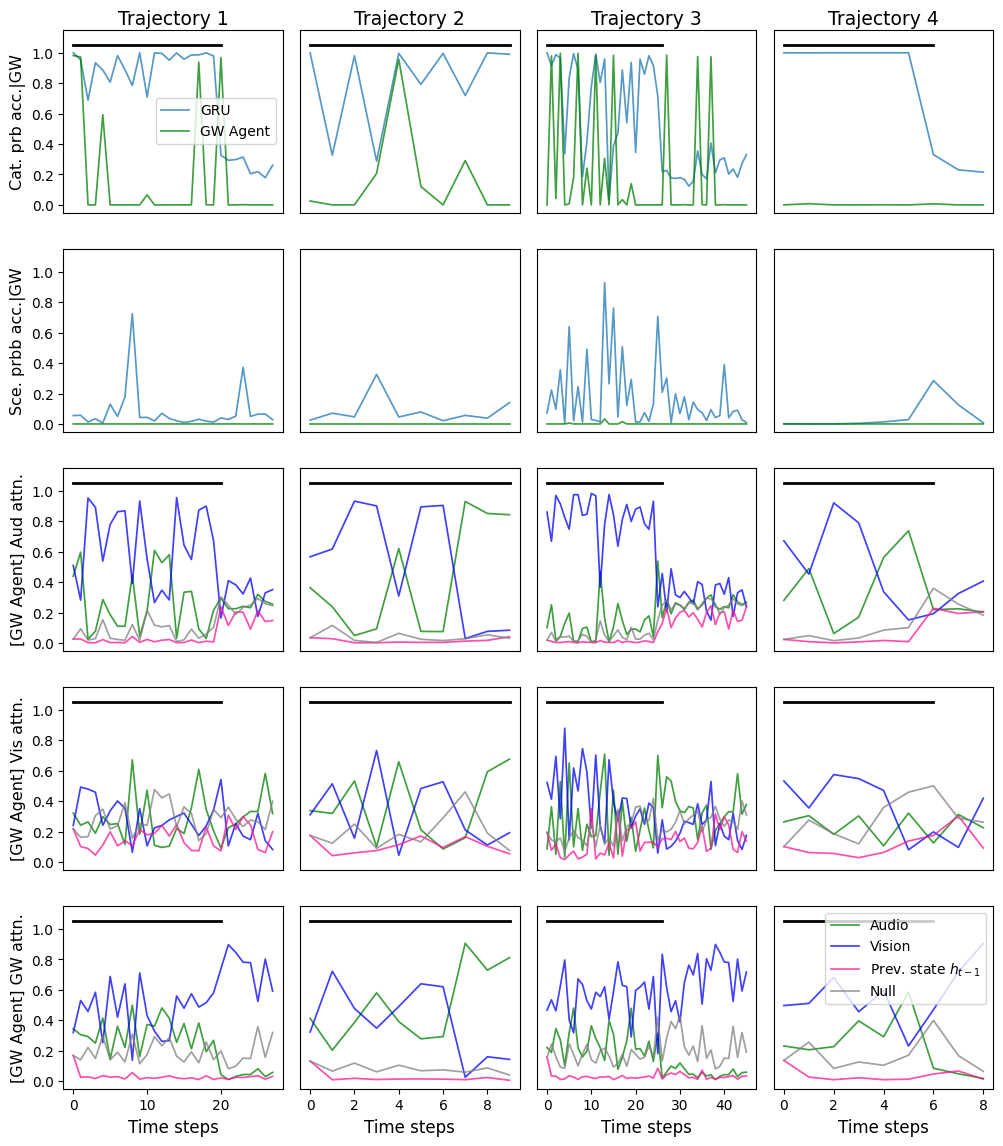

In [31]:
MOD_AXIS_TO_NAME = {0: "Audio", 1: "Vision", 2: r"Prev. state $h_{t-1}$", 3: "Null"}
MOD_AXIS_TO_COLOR = { 0: "green", 1: "blue", 2: "deeppink", 3: "grey"}

N_TRAJS = 4
mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use("ggplot")
fig, axes = plt.subplots(5, N_TRAJS, figsize=(N_TRAJS * 3, 5 * 2.75))

TRAJS_OF_INTEREST_DICT = {
  0: { "category": "chair", "scene": "gTV8FGcVJC9", "traj_idx": 0},
  1: { "category": "chair", "scene": "gTV8FGcVJC9", "traj_idx": 1},
  2: { "category": "chair", "scene": "gTV8FGcVJC9", "traj_idx": 2},
  3: { "category": "chair", "scene": "gTV8FGcVJC9", "traj_idx": 3},
  # 4: { "category": "chair", "scene": "gTV8FGcVJC9", "traj_idx": 4},
}
# TODO: recover this based on TRAJS_OF_INTEREST
CATEGORIES_OF_INTEREST_PLOTS = [
    "chair",
    # "picture",
    # "cabinet",
    # "plant",
    # "cushion",
    # "table"
]
SCENES_OF_INTEREST_PLOTS = [
    "gTV8FGcVJC9",
    # "D7N2EKCX4Sj",
    # "b8cTxDM8gDG",
    # "Vvot9Ly1tCj",
    # "vyrNrziPKCB"
] # ['gTV8FGcVJC9', 'b8cTxDM8gDG', 'D7N2EKCX4Sj', 'Vvot9Ly1tCj', 'vyrNrziPKCB']
TRAJ_INDICES_PLOTS = [
    0,
    1,
    2,
    3,
    4
] # Only select trajectories in indices of interest

AGENT_GROUPS_OF_INTEREST = {
  "GRU H=512": {
    111: "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111",
    # 222: "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111",
  },
  "GW H=64": {
    111: "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111",
    222: "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222",
  },
  # "GW H=512": {
  #   111: "",
  #   222: "",
  # },
}
# TODO: functionalize
for ridx in range(5):
  for cidx in range(N_TRAJS):
    # Tweak the ylimit for all plots
    axes[ridx, cidx].set_ylim(-0.05, 1.15)

    if ridx == 0:
      axes[ridx, cidx].xaxis.set_label_position("top")
      axes[ridx, cidx].set_xlabel(f"Trajectory {cidx+1}", fontsize=13.5)
    if cidx > 0:
      axes[ridx, cidx].yaxis.set_major_locator(ticker.NullLocator())
    if ridx < 4:
      axes[ridx, cidx].xaxis.set_major_locator(ticker.NullLocator())
    else:
      axes[ridx, cidx].set_xlabel("Time steps", fontsize=12)

# Plots labelling
ylabel_fontsize = 11.5
axes[0, 0].set_ylabel("Cat. prb acc.|GW", fontsize=ylabel_fontsize)
axes[1, 0].set_ylabel("Sce. prbb acc.|GW", fontsize=ylabel_fontsize)
axes[2, 0].set_ylabel("[GW Agent] Aud attn.", fontsize=ylabel_fontsize)
axes[3, 0].set_ylabel("[GW Agent] Vis attn.", fontsize=ylabel_fontsize)
axes[4, 0].set_ylabel("[GW Agent] GW attn.", fontsize=ylabel_fontsize)

# Iterate over traj data, plot if of interest
n_traj_plotted = 0

# TODO: rework the plotting to satisfy:
# 1. Iterate over the trajectories of interest
# 2. Group agent runs by seed, give them a name

for catname, cat_dict in CAT_SCENE_TRAJ_PROBING_RESULTS.items():
  if cat not in CATEGORIES_OF_INTEREST_PLOTS:
      continue
  print(f"  {cat}")

  for scene, scene_dict in cat_dict.items():
    if scene not in SCENES_OF_INTEREST_PLOTS:
        continue
    print(f"    {scene}")

    for traj_idx, traj_dict in scene_dict.items():
      if traj_idx not in TRAJ_INDICES:
          continue

      of_interest = False
      for traj_interest_data in TRAJS_OF_INTEREST_DICT.values():
        if f"{catname}{scene}{traj_idx}" == \
          f"{traj_interest_data['category']}{traj_interest_data['scene']}{traj_interest_data['traj_idx']}":
          of_interest = True
          break
      
      if not of_interest:
        continue

      # Load the current trajectory's data
      # TODO: could count this during the processing phase somehow ?
      obs_dict_list, _, _, _ = \
          get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, cat, scene, traj_idx, tensorize=False)
      
      T = len(CAT_SCENE_TRAJS_FEATURES[cat][scene][traj_idx]["target_category_idx_list"])

      mute_step = 0
      spectrogram_obs_list = np.array([d["spectrogram"] for d in obs_dict_list])
      for t in range(T):
        if spectrogram_obs_list[t].sum() >= 1e-6:
          mute_step += 1
        else:
          break
      mute_step = min(mute_step, T-1)

      print(f"     Traj: {traj_idx} | Length: {T}")

      # Plot the probe accuracies
      xs = np.arange(T)

      agent_model_name = "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__grulynrm__entcoef_0.2__no_cew_seed_111"
      axes[0, n_traj_plotted].plot(AGENT_CORRECT_TARGET_PROBS[catname][scene][traj_idx][agent_model_name]["category"], label="GRU", linewidth=1.25, alpha=0.75)
      axes[1, n_traj_plotted].plot(AGENT_CORRECT_TARGET_PROBS[catname][scene][traj_idx][agent_model_name]["scene"], label="_GRU", linewidth=1.25, alpha=0.75)
      # axes[0, n_traj_plotted].scatter(xs, AGENT_CORRECT_TARGET_PROBS[catname][scene][traj_idx][agent_model_name]["category"], s=12.5)
      # axes[1, n_traj_plotted].scatter(xs, AGENT_CORRECT_TARGET_PROBS[catname][scene][traj_idx][agent_model_name]["scene"], s=12.5)

      # agent_model_name = "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__seed_111"
      # agent_model_name = "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_111"
      agent_model_name = "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__h_64__seed_222"
      axes[0, n_traj_plotted].plot(AGENT_CORRECT_TARGET_PROBS[catname][scene][traj_idx][agent_model_name]["category"], c="green", label="GW Agent", linewidth=1.25, alpha=0.75)
      axes[1, n_traj_plotted].plot(AGENT_CORRECT_TARGET_PROBS[catname][scene][traj_idx][agent_model_name]["scene"], c="green", label="_GW Agent", linewidth=1.25, alpha=0.75)
      # axes[0, n_traj_plotted].scatter(xs, AGENT_CORRECT_TARGET_PROBS[catname][scene][traj_idx][agent_model_name]["category"], s=12.5, c="green")
      # axes[1, n_traj_plotted].scatter(xs, AGENT_CORRECT_TARGET_PROBS[catname][scene][traj_idx][agent_model_name]["scene"], s=12.5, c="green")

      ## Plot the black bar
      [axes[i, n_traj_plotted].plot([0, mute_step], [1.05, 1.05], c="black", linewidth=2) for i in [0, 2, 3, 4]]

      # Plot the attention weights for the GWTv3 variant
      att_weights = CAT_SCENE_TRAJS_FEATURES[catname][scene][traj_idx][agent_model_name]["state_encoder.ca.mha"][1][:, 0, :, :]

      for mod_idx in range(2, 5):
        for mod_axis in range(4):
          mod_idx_offset = mod_idx-2
          axes[mod_idx, n_traj_plotted].plot(xs, att_weights[:, mod_idx_offset, mod_axis], 
            linewidth=1.25,
            label=MOD_AXIS_TO_NAME[mod_axis],
            color=MOD_AXIS_TO_COLOR[mod_axis],
            alpha=0.75)
          # axes[mod_idx, n_traj_plotted].scatter(xs, att_weights[:, mod_idx_offset, mod_axis], s=12.5,
          #   color=MOD_AXIS_TO_COLOR[mod_axis],
          #   label=f"_{MOD_AXIS_TO_NAME[mod_axis]}")

      # Set legend using dashed lines before doing the dots / scater
      axes[0, 0].legend()
      axes[4, N_TRAJS-1].legend()

      n_traj_plotted += 1

      if n_traj_plotted == N_TRAJS:
        break
    
    if n_traj_plotted == N_TRAJS:
      break
  
  if n_traj_plotted == N_TRAJS:
    break


fig.subplots_adjust(wspace=0.08)
# fig.tight_layout()
fig.show()

In [63]:
AGENT_CORRECT_TARGET_PROBS.keys()
AGENT_CORRECT_TARGET_PROBS["chair"].keys()
AGENT_CORRECT_TARGET_PROBS["chair"]["gTV8FGcVJC9"].keys()

dict_keys([1])

In [39]:
# Quick architecture test to see if we can conserve the dim. of 
feat_size = 512
hid_size = 64
mha = nn.MultiheadAttention(
  hid_size,
  1,
  dropout=0.0,
  add_zero_attn=False,
  batch_first=True,
  kdim=feat_size,
  vdim=feat_size,
)

# Original inputs
prev_gw = th.zeros([1, 1, hid_size])
aud_feats = th.zeros((1, 1, feat_size))
vis_feats = th.zeros((1, 1, feat_size))
nul_feats = th.zeros((1, 1, feat_size))

q = th.cat([aud_feats, vis_feats, prev_gw], dim=1)
k = th.cat([aud_feats, vis_feats, prev_gw, nul_feats], dim=1)
v = th.cat([aud_feats, vis_feats, prev_gw, nul_feats], dim=1)

attn_values, attn_weights = mha(q, k, v); attn_values.shape, attn_weights.shape

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 512 but got size 64 for tensor number 2 in the list.